In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from glob import glob

import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from fastcore.xtras import load_pickle
from guacamol.utils.chemistry import is_valid

from gptchem.data import get_photoswitch_data
from gptchem.evaluator import evaluate_generated_smiles, evaluate_photoswitch_smiles_pred, is_in_pubchem
from gptchem.settings import ONE_COL_GOLDEN_RATIO_HEIGHT_INCH, ONE_COL_WIDTH_INCH


from rdkit.Contrib.SA_Score.sascorer import calculateScore as calculate_sascore
from rdkit import Chem 

from scipy.stats import sem


import matplotx

from gptchem.plotsettings import * 
%matplotlib inline

In [3]:
def get_sa_scores(smiles):
    sa_scores = []
    for smiles in smiles:
        try:
            mol = Chem.MolFromSmiles(smiles)
            sa_scores.append(calculate_sascore(mol))
        except: 
            pass
    return sa_scores

In [4]:
from rdkit import Chem

In [5]:
all_res = glob("out/**/*.pkl")

In [6]:
res = load_pickle(all_res[0])

In [7]:
from collections import defaultdict

In [8]:
def contains_azo(smiles):
    mol = Chem.MolFromSmiles(smiles)
    # check if there is a N#N bond
    smarts = "[NX2]=N"
    return mol.HasSubstructMatch(Chem.MolFromSmarts(smarts))

In [41]:
res

{'train_size': 92,
 'noise_level': 1.0,
 'num_samples': 100,
 'temperatures': [0, 0.1, 0.2, 0.5, 0.75, 1.0, 1.25, 1.5, 2.0],
 'res_at_temp': [{'completions': {'choices': [' CC1=C(C(C)=NN1)/N=N/C2=CC=C(C(O)=O)C=C2',
     ' CC1=C(C(C)=NN1)/N=N/C2=CC=C(C(O)=O)C=C2',
     ' CC1=C(C(C)=NN1)/N=N/C2=CC=C(C(O)=O)C=C2',
     ' CC1=C(C(C)=NN1)/N=N/C2=CC=C(C(O)=O)C=C2',
     ' CC1=C(C(C)=NN1)/N=N/C2=CC=C(C(O)=O)C=C2'],
    'logprobs': [None, None, None, None, None],
    'model': 'ada:ft-lsmoepfl-2023-02-03-19-32-46'},
   'generated_smiles': (#5) ['CC1=C(C(C)=NN1)/N=N/C2=CC=C(C(O)=O)C=C2','CC1=C(C(C)=NN1)/N=N/C2=CC=C(C(O)=O)C=C2','CC1=C(C(C)=NN1)/N=N/C2=CC=C(C(O)=O)C=C2','CC1=C(C(C)=NN1)/N=N/C2=CC=C(C(O)=O)C=C2','CC1=C(C(C)=NN1)/N=N/C2=CC=C(C(O)=O)C=C2'],
   'train_smiles': 0              C[N]1C=CC(=N1)N=NC2=CC=CC=C2
   1              C[N]1C=NC(=N1)N=NC2=CC=CC=C2
   2           C[N]1C=C(C)C(=N1)N=NC2=CC=CC=C2
   3              C[N]1C=C(C=N1)N=NC2=CC=CC=C2
   4          C[N]1N=C(C)C(=C1C)N=NC2=CC=C

In [54]:
compiled_res = []
generated_smiles = set()
generated_smiles_w_azos = set()

generated_smiles_w_azos_at_temp = defaultdict(set)
generated_smiles_at_temp = defaultdict(set)

for res_path in all_res:
    res = load_pickle(res_path)
    for temp_res in res["res_at_temp"]:
        try:
            metrics = {
                "noise_level": res["noise_level"],
                "temp": temp_res["temperature"],
                "frac_valid": temp_res["frac_valid"],
                "frac_unique": temp_res["frac_unique"],
                "frac_smiles_in_train": sum([s.split()[0] in temp_res['train_smiles'].values for s in temp_res["valid_smiles"]]) / len(temp_res["valid_smiles"]),
                 "frac_smiles_in_pubchem": sum([is_in_pubchem(s.split()[0]) for s in temp_res["valid_smiles"]]) / len(temp_res["valid_smiles"]), 
                "kld": temp_res["kld"],
                "frechet_d": temp_res["frechet_d"],
                "frechet_score": temp_res["frechet_score"],
                "frac_contains_azo": sum([contains_azo(s) for s in temp_res["valid_smiles"]])
                / len(temp_res["valid_smiles"]),
            }

            generated_smiles.update([s for s in temp_res["generated_smiles"] if is_valid(s)])
            v_w_azo = [s for s in temp_res["generated_smiles"] if is_valid(s) and contains_azo(s)]
            generated_smiles_w_azos.update(v_w_azo)
            generated_smiles_w_azos_at_temp[temp_res["temperature"]].update(v_w_azo)

            v = [s for s in temp_res["generated_smiles"] if is_valid(s)]
            generated_smiles_at_temp[temp_res["temperature"]].update(v)

            for me, v in temp_res['constrain_satisfaction']["e_pi_pi_star_metrics"].items():
                metrics["e_pi_pi_star_" + me] = v

            for me, v in temp_res['constrain_satisfaction']["z_pi_pi_star_metrics"].items():
                metrics["z_pi_pi_star_" + me] = v

            for me, v in temp_res['constrain_satisfaction_novel']["e_pi_pi_star_metrics"].items():
                metrics["e_pi_pi_star_novel_" + me] = v

            for me, v in temp_res['constrain_satisfaction_novel']["z_pi_pi_star_metrics"].items():
                metrics["z_pi_pi_star_novel_" + me] = v
            metrics['sa_score'] = np.mean(get_sa_scores(v_w_azo))
            compiled_res.append(metrics)
        except Exception as e:
            print(e)
            pass

'e_pi_pi_star_metrics'
'e_pi_pi_star_metrics'
'e_pi_pi_star_metrics'
'e_pi_pi_star_metrics'
'e_pi_pi_star_metrics'
'e_pi_pi_star_metrics'
'e_pi_pi_star_metrics'
'e_pi_pi_star_metrics'
'e_pi_pi_star_metrics'
'e_pi_pi_star_metrics'
'e_pi_pi_star_metrics'
'e_pi_pi_star_metrics'
'e_pi_pi_star_metrics'
'e_pi_pi_star_metrics'
'e_pi_pi_star_metrics'
'e_pi_pi_star_metrics'
'e_pi_pi_star_metrics'
'e_pi_pi_star_metrics'


In [55]:
contains_azo(list(generated_smiles)[5])

True

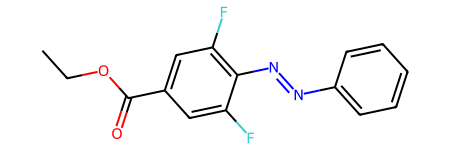

In [56]:
Chem.MolFromSmiles(list(generated_smiles)[0])

In [57]:
df = pd.DataFrame(compiled_res)

In [58]:
grouped = df.groupby(["temp"]).agg(["mean", "std", sem, "count"])

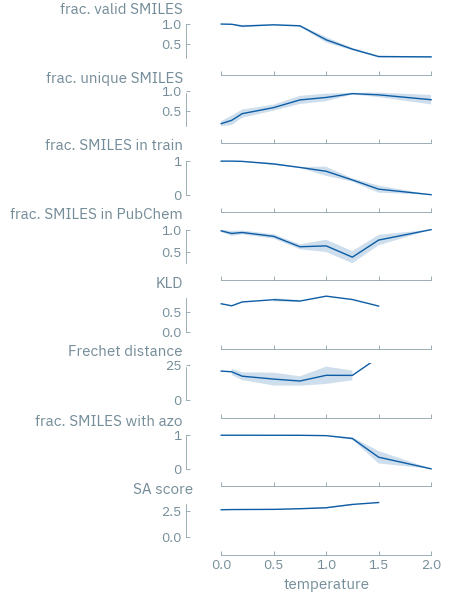

In [59]:
fig, ax = plt.subplots(8, 1, sharex="col", figsize=(ONE_COL_WIDTH_INCH, 2 * ONE_COL_WIDTH_INCH))
ax[0].plot(grouped.index, grouped["frac_valid"]["mean"], label="frac_valid")
ax[0].fill_between(
    grouped.index,
    grouped["frac_valid"]["mean"] - grouped["frac_valid"]["sem"],
    grouped["frac_valid"]["mean"] + grouped["frac_valid"]["sem"],
    alpha=0.2,
)

ylabel_top("frac. valid SMILES", ax=ax[0], x_pad=0.05,  y_pad=-0.02)

range_frame(
    ax[0],
    grouped.index,
    np.nan_to_num(
        np.stack(
            [
                grouped["frac_valid"]["mean"] - grouped["frac_valid"]["sem"],
                grouped["frac_valid"]["mean"] + grouped["frac_valid"]["sem"],
            ]
        ).flatten(),
        grouped["frac_valid"]["mean"].mean(),
    ),
)

ax[1].plot(grouped.index, grouped["frac_unique"]["mean"], label="frac_unique")
ax[1].fill_between(
    grouped.index,
    grouped["frac_unique"]["mean"] - grouped["frac_unique"]["sem"],
    grouped["frac_unique"]["mean"] + grouped["frac_unique"]["sem"],
    alpha=0.2,
)

range_frame(
    ax[1],
    grouped.index,
    np.nan_to_num(
        np.stack(
            [
                grouped["frac_unique"]["mean"] - grouped["frac_unique"]["sem"],
                grouped["frac_unique"]["mean"] + grouped["frac_unique"]["sem"],
            ]
        ).flatten(),
        grouped["frac_unique"]["mean"].mean(),
    ),
)

ylabel_top("frac. unique SMILES", ax=ax[1], x_pad=0.05)

ax[2].plot(grouped.index, grouped["frac_smiles_in_train"]["mean"], label="frac_smiles_in_train")
ax[2].fill_between(
    grouped.index,
    grouped["frac_smiles_in_train"]["mean"] - grouped["frac_smiles_in_train"]["sem"],
    grouped["frac_smiles_in_train"]["mean"] + grouped["frac_smiles_in_train"]["sem"],
    alpha=0.2,
)

ylabel_top("frac. SMILES in train", ax=ax[2], x_pad=0.05)

range_frame(
    ax[2],
    grouped.index,
    np.nan_to_num(
        np.stack(
            [
                grouped["frac_smiles_in_train"]["mean"] - grouped["frac_smiles_in_train"]["sem"],
                grouped["frac_smiles_in_train"]["mean"] + grouped["frac_smiles_in_train"]["sem"],
            ]
        ).flatten(),
        grouped["frac_smiles_in_train"]["mean"].mean(),
    ),
)


ax[3].plot(grouped.index, grouped["frac_smiles_in_pubchem"]["mean"], label="frac_smiles_in_pubchem")
ax[3].fill_between(
    grouped.index,
    grouped["frac_smiles_in_pubchem"]["mean"] - grouped["frac_smiles_in_pubchem"]["sem"],
    grouped["frac_smiles_in_pubchem"]["mean"] + grouped["frac_smiles_in_pubchem"]["sem"],
    alpha=0.2,
)

ylabel_top("frac. SMILES in PubChem", ax=ax[3], x_pad=0.05,  y_pad=0.01)


range_frame(
    ax[3],
    grouped.index,
    np.nan_to_num(
        np.stack(
            [
                grouped["frac_smiles_in_pubchem"]["mean"]
                - grouped["frac_smiles_in_pubchem"]["sem"],
                grouped["frac_smiles_in_pubchem"]["mean"]
                + grouped["frac_smiles_in_pubchem"]["sem"],
            ]
        ).flatten(),
        grouped["frac_smiles_in_pubchem"]["mean"].mean(),
    ),
)


ax[4].plot(grouped.index, grouped["kld"]["mean"], label="kld")
ax[4].fill_between(
    grouped.index,
    grouped["kld"]["mean"] - grouped["kld"]["sem"],
    grouped["kld"]["mean"] + grouped["kld"]["sem"],
    alpha=0.2,
)

ylabel_top("KLD", ax=ax[4], x_pad=0.05,  y_pad=0.05)



range_frame(
    ax[4],
    grouped.index,
    np.nan_to_num(
        np.stack(
            [
                grouped["kld"]["mean"]
                - grouped["kld"]["sem"],
                grouped["kld"]["mean"]
                + grouped["kld"]["sem"],
            ]
        ).flatten(),
        grouped["kld"]["mean"].mean(),
    ),
)



ax[5].plot(grouped.index, grouped["frechet_d"]["mean"], label="frechet_d")
ax[5].fill_between(
    grouped.index,
    grouped["frechet_d"]["mean"] - grouped["frechet_d"]["sem"],
    grouped["frechet_d"]["mean"] + grouped["frechet_d"]["sem"],
    alpha=0.2,
)

ylabel_top("Frechet distance", ax=ax[5], x_pad=0.05,  y_pad=0.02)



range_frame(
    ax[5],
    grouped.index,
    np.nan_to_num(
        np.stack(
            [
                grouped["frechet_d"]["mean"]
                - grouped["frechet_d"]["sem"],
                grouped["frechet_d"]["mean"]
                + grouped["frechet_d"]["sem"],
            ]
        ).flatten(),
        grouped["frechet_d"]["mean"].mean(),
    ),
)



ax[6].plot(grouped.index, grouped["frac_contains_azo"]["mean"], label="frechet_score")
ax[6].fill_between(
    grouped.index,
    grouped["frac_contains_azo"]["mean"] - grouped["frac_contains_azo"]["sem"],
    grouped["frac_contains_azo"]["mean"] + grouped["frac_contains_azo"]["sem"],
    alpha=0.2,
)

ylabel_top("frac. SMILES with azo", ax=ax[6], x_pad=0.05, y_pad=-0.03)

range_frame(
    ax[6],
    grouped.index,
    np.nan_to_num(
        np.stack(
            [
                grouped["frac_contains_azo"]["mean"]
                - grouped["frac_contains_azo"]["sem"],
                grouped["frac_contains_azo"]["mean"]
                + grouped["frac_contains_azo"]["sem"],
            ]
        ).flatten(),
        grouped["frac_contains_azo"]["mean"].mean(),
    ),
)

ax[7].plot(grouped.index, grouped["sa_score"]["mean"], label="frechet_score")
ax[7].fill_between(
    grouped.index,
    grouped["sa_score"]["mean"] - grouped["sa_score"]["sem"],
    grouped["sa_score"]["mean"] + grouped["sa_score"]["sem"],
    alpha=0.2,
)

ylabel_top("SA score", ax=ax[7])

range_frame(
    ax[7],
    grouped.index,
    np.nan_to_num(
        np.stack(
            [
                grouped["sa_score"]["mean"]
                - grouped["sa_score"]["sem"],
                grouped["sa_score"]["mean"]
                + grouped["sa_score"]["sem"],
            ]
        ).flatten(),
        grouped["sa_score"]["mean"].mean(),
    ),
)



ax[-1].set_xlabel("temperature", labelpad=4)

plt.subplots_adjust(hspace=0.7, top=1, bottom=0.2)

fig.savefig("photoswitch_extrapolation_smiles_metrics.pdf", bbox_inches="tight")

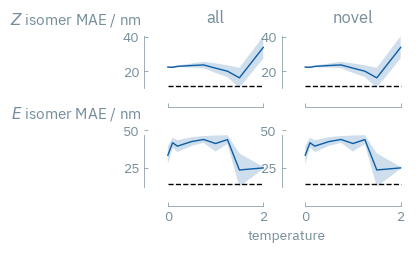

In [ ]:
# with plt.style.context(matplotx.styles.dufte):
fig, ax = plt.subplots(
    2, 2, sharex="all", figsize=(ONE_COL_WIDTH_INCH, ONE_COL_GOLDEN_RATIO_HEIGHT_INCH)
)

ax[0][0].plot(
    grouped.index,
    grouped["z_pi_pi_star_mean_absolute_error"]["mean"],
    label="e_pi_pi_star_metrics",
)
ax[0][0].fill_between(
    grouped.index,
    grouped["z_pi_pi_star_mean_absolute_error"]["mean"]
    - grouped["z_pi_pi_star_mean_absolute_error"]["sem"],
    grouped["z_pi_pi_star_mean_absolute_error"]["mean"]
    + grouped["z_pi_pi_star_mean_absolute_error"]["sem"],
    alpha=0.2,
)

ax[0][1].plot(
    grouped.index,
    grouped["z_pi_pi_star_novel_mean_absolute_error"]["mean"],
    label="e_pi_pi_star_metrics",
)
ax[0][1].fill_between(
    grouped.index,
    grouped["z_pi_pi_star_novel_mean_absolute_error"]["mean"]
    - grouped["z_pi_pi_star_novel_mean_absolute_error"]["sem"],
    grouped["z_pi_pi_star_novel_mean_absolute_error"]["mean"]
    + grouped["z_pi_pi_star_novel_mean_absolute_error"]["sem"],
    alpha=0.2,
)

range_frame(
    ax[0][0],
    grouped.index,
    np.nan_to_num(
        np.stack(
            [
                grouped["z_pi_pi_star_mean_absolute_error"]["mean"]
                - grouped["z_pi_pi_star_mean_absolute_error"]["sem"],
                grouped["z_pi_pi_star_mean_absolute_error"]["mean"]
                + grouped["z_pi_pi_star_mean_absolute_error"]["sem"],
            ]
        ).flatten(),
        grouped["z_pi_pi_star_mean_absolute_error"]["mean"].mean(),
    ),
)




range_frame(
    ax[0][1],
    grouped.index,
    np.nan_to_num(
        np.stack(
            [
                grouped["z_pi_pi_star_novel_mean_absolute_error"]["mean"]
                - grouped["z_pi_pi_star_novel_mean_absolute_error"]["sem"],
                grouped["z_pi_pi_star_novel_mean_absolute_error"]["mean"]
                + grouped["z_pi_pi_star_novel_mean_absolute_error"]["sem"],
            ]
        ).flatten(),
        grouped["z_pi_pi_star_novel_mean_absolute_error"]["mean"].mean(),
    ),
)
# ylabel_top("MAE / nm", ax=ax[0][0])

ax[0][0].hlines(11.616605626696359, 0, 2, color="k", linestyle="--")
ax[0][1].hlines(11.616605626696359, 0, 2, color="k", linestyle="--")
# ax[0].set_ylim(8, 35)

ax[1][0].plot(
    grouped.index,
    grouped["e_pi_pi_star_mean_absolute_error"]["mean"],
    label="e_pi_pi_star_metrics",
)
ax[1][0].fill_between(
    grouped.index,
    grouped["e_pi_pi_star_mean_absolute_error"]["mean"]
    - grouped["e_pi_pi_star_mean_absolute_error"]["sem"],
    grouped["e_pi_pi_star_mean_absolute_error"]["mean"]
    + grouped["e_pi_pi_star_mean_absolute_error"]["sem"],
    alpha=0.2,
)

range_frame(
    ax[1][0],
    grouped.index,
    np.nan_to_num(
        np.stack(
            [
                grouped["e_pi_pi_star_mean_absolute_error"]["mean"]
                - grouped["e_pi_pi_star_mean_absolute_error"]["sem"],
                grouped["e_pi_pi_star_mean_absolute_error"]["mean"]
                + grouped["e_pi_pi_star_mean_absolute_error"]["sem"],
            ]
        ).flatten(),
        grouped["e_pi_pi_star_mean_absolute_error"]["mean"].mean(),
    ),
)


ax[1][1].plot(
    grouped.index,
    grouped["e_pi_pi_star_novel_mean_absolute_error"]["mean"],
    label="e_pi_pi_star_metrics",
)
ax[1][1].fill_between(
    grouped.index,
    grouped["e_pi_pi_star_novel_mean_absolute_error"]["mean"]
    - grouped["e_pi_pi_star_novel_mean_absolute_error"]["sem"],
    grouped["e_pi_pi_star_novel_mean_absolute_error"]["mean"]
    + grouped["e_pi_pi_star_novel_mean_absolute_error"]["sem"],
    alpha=0.2,
)



range_frame(
    ax[1][1],
    grouped.index,
    np.nan_to_num(
        np.stack(
            [
                grouped["e_pi_pi_star_novel_mean_absolute_error"]["mean"]
                - grouped["e_pi_pi_star_novel_mean_absolute_error"]["sem"],
                grouped["e_pi_pi_star_novel_mean_absolute_error"]["mean"]
                + grouped["e_pi_pi_star_novel_mean_absolute_error"]["sem"],
            ]
        ).flatten(),
        grouped["e_pi_pi_star_novel_mean_absolute_error"]["mean"].mean(),
    ),
)



# ylabel_top("MAE / nm", ax=ax[1][0])

ax[1][0].hlines(14.38998132190228, 0, 2, color="k", linestyle="--")
ax[1][1].hlines(14.38998132190228, 0, 2, color="k", linestyle="--")


ax[0][0].set_title('all')
ax[0][1].set_title('novel')

ylabel_top(r'$Z$ isomer MAE / nm', ax[0][0], x_pad=0.1)
ylabel_top(r'$E$ isomer MAE / nm', ax[1][0], x_pad=0.1)

fig.text(0.4, -0.04, "temperature")
plt.subplots_adjust(hspace=0.6, top=1, bottom=0.2)
fig.savefig("extrapolation_photoswitch_constrain_matches.pdf", bbox_inches="tight")

## Visualize

In [37]:
import numpy as np
import tmap as tm
from faerun import Faerun
from mhfp.encoder import MHFPEncoder
from rdkit.Chem import AllChem
from tqdm import tqdm

In [38]:
import os
import shutil

In [39]:
def make_figure(temp):
    path = f"plots_all/{temp}"
    os.makedirs(path, exist_ok=True)
    enc = MHFPEncoder()
    lf = tm.LSHForest(2048, 128)
    train_data = get_photoswitch_data()
    train_smiles = train_data["SMILES"].values
    all_smiles = set(train_smiles) | generated_smiles_at_temp[temp]
    in_pubchem = [is_in_pubchem(s) for s in all_smiles]

    fps = []
    labels = []

    for smiles in tqdm(all_smiles):
        mol = AllChem.MolFromSmiles(smiles)
        fps.append(tm.VectorUint(enc.encode_mol(mol, min_radius=0)))
        if smiles not in generated_smiles_at_temp[temp]:    
            labels.append(0)
        elif smiles in train_smiles:    
            labels.append(1)
        elif is_in_pubchem(smiles):
            labels.append(2)
        else:
            labels.append(3)

    lf.batch_add(fps)
    lf.index()
    cfg = tm.LayoutConfiguration()
    cfg.k = 100
    cfg.sl_extra_scaling_steps = 6
    cfg.sl_repeats = 2
    cfg.mmm_repeats = 2
    cfg.node_size = 2
    x, y, s, t, _ = tm.layout_from_lsh_forest(lf, config=cfg)

    f = Faerun(
        clear_color="#FFFFFF",
        coords=False,
        view="free",
       # impress='made with <a href="http://tmap.gdb.tools" target="_blank">tmap</a><br />and <a href="https://github.com/reymond-group/faerun-python" target="_blank">faerun</a>',
    )
    f.add_scatter(
        f"Photoswitches",
        {
            "x": x,
            "y": y,
            "c": labels,
            "labels": all_smiles,
        },
        colormap="Set1",
        categorical=True,
        shader="sphere",
        has_legend=True,
        point_scale=5,
        legend_labels=[(0, "database, not generated"), (1, "in database"), (2, "in PubChem"), (3, "novel")],
        max_point_size=5000,
    )
    f.add_tree(
        "Photoswitches_tree",
        {
            "from": s,
            "to": t,
        },
        point_helper="Photoswitches",
    )
    f.plot("Photoswitches", template="smiles")

    shutil.copy("Photoswitches.html", path)

In [40]:
for temp in [0, 0.1, 0.2, 0.5, 0.75, 1.0, 1.25, 1.5, 2.0]:
    make_figure(temp)

100%|██████████| 404/404 [00:03<00:00, 118.15it/s]


/Users/kevinmaikjablonka/git/kjappelbaum/gptchem/experiments/05_inverse/photoswitch/extrapolation/Photoswitches.html

100%|██████████| 403/403 [00:03<00:00, 117.46it/s]


/Users/kevinmaikjablonka/git/kjappelbaum/gptchem/experiments/05_inverse/photoswitch/extrapolation/Photoswitches.html

100%|██████████| 405/405 [00:03<00:00, 120.33it/s]


/Users/kevinmaikjablonka/git/kjappelbaum/gptchem/experiments/05_inverse/photoswitch/extrapolation/Photoswitches.html

100%|██████████| 417/417 [00:03<00:00, 116.86it/s]


/Users/kevinmaikjablonka/git/kjappelbaum/gptchem/experiments/05_inverse/photoswitch/extrapolation/Photoswitches.html

100%|██████████| 440/440 [00:03<00:00, 120.73it/s]


/Users/kevinmaikjablonka/git/kjappelbaum/gptchem/experiments/05_inverse/photoswitch/extrapolation/Photoswitches.html

100%|██████████| 445/445 [00:03<00:00, 119.99it/s]


/Users/kevinmaikjablonka/git/kjappelbaum/gptchem/experiments/05_inverse/photoswitch/extrapolation/Photoswitches.html

100%|██████████| 452/452 [00:03<00:00, 117.95it/s]


/Users/kevinmaikjablonka/git/kjappelbaum/gptchem/experiments/05_inverse/photoswitch/extrapolation/Photoswitches.html

100%|██████████| 434/434 [00:03<00:00, 121.87it/s]


/Users/kevinmaikjablonka/git/kjappelbaum/gptchem/experiments/05_inverse/photoswitch/extrapolation/Photoswitches.html

100%|██████████| 421/421 [00:03<00:00, 119.14it/s]


/Users/kevinmaikjablonka/git/kjappelbaum/gptchem/experiments/05_inverse/photoswitch/extrapolation/Photoswitches.html

## Plot histograms

In [19]:
data = get_photoswitch_data()

In [20]:
data_subset = data.dropna(
    subset=["E isomer pi-pi* wavelength in nm", "SMILES", "Z isomer pi-pi* wavelength in nm"]
)

In [21]:
data_tresholded = data_subset[data_subset["E isomer pi-pi* wavelength in nm"] < 350]

In [22]:
all_data = pd.concat([data_subset, data_tresholded])
all_data["kind"] = ["all"] * len(data_subset) + ["tresholded"] * len(data_tresholded)

In [23]:
from gptchem.evaluator import predict_photoswitch

In [24]:
predictions = []

for smile in generated_smiles:
    pred_e_pi_pi_star, pred_z_pi_pi_star = predict_photoswitch(smile)
    predictions.append(
        {
            "SMILES": smile,
            "E isomer pi-pi* wavelength in nm": pred_e_pi_pi_star[0][0],
            "Z isomer pi-pi* wavelength in nm": pred_z_pi_pi_star[0][0],
            "kind": "generated",
        }
    )

In [25]:
pred_frame = pd.DataFrame(predictions).drop_duplicates(subset=["SMILES"])

In [26]:
all_data = pd.concat([all_data, pred_frame])

In [27]:
all_data

,SMILES,rate of thermal isomerisation from Z-E in s-1,Solvent used for thermal isomerisation rates,Z PhotoStationaryState,E PhotoStationaryState,E isomer pi-pi* wavelength in nm,Extinction,E isomer n-pi* wavelength in nm,Extinction coefficient in M-1 cm-1,Z isomer pi-pi* wavelength in nm,...,CAM-B3LYP/6-31G** DFT Z isomer n-pi* wavelength in nm,BHLYP/6-31G* DFT E isomer pi-pi* wavelength in nm,BHLYP/6-31G* DFT E isomer n-pi* wavelength in nm,BHLYP/6-31G* Z isomer pi-pi* wavelength in nm,BHLYP/6-31G* DFT Z isomer n-pi* wavelength in nm,name,selfies,wavelength_cat,inchi,kind
0,C[N]1C=CC(=N1)N=NC2=CC=CC=C2,2.100000e-07,MeCN,76.0,72.0,310.000000,1.67,442.0,0.0373,290.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,[C][NH0][N][=N][C][=Branch1][Ring2][=N][Ring1]...,very small,InChI=1S/C10H10N4/c1-14-8-7-10(13-14)12-11-9-5...,all
1,C[N]1C=NC(=N1)N=NC2=CC=CC=C2,3.800000e-07,MeCN,90.0,84.0,310.000000,1.87,438.0,0.0505,272.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,[C][NH0][C][=N][C][=Branch1][Ring2][=N][Ring1]...,very small,InChI=1S/C9H9N5/c1-14-7-10-9(13-14)12-11-8-5-3...,all
2,C[N]1C=C(C)C(=N1)N=NC2=CC=CC=C2,1.500000e-06,MeCN,96.0,87.0,325.000000,1.74,428.0,0.0612,286.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,[C][NH0][C][=C][Branch1][C][C][C][=Branch1][Ri...,very small,InChI=1S/C11H12N4/c1-9-8-15(2)14-11(9)13-12-10...,all
3,C[N]1C=C(C=N1)N=NC2=CC=CC=C2,7.600000e-09,MeCN,98.0,70.0,328.000000,1.66,417.0,0.0640,275.000000,...,401.0,NaN,NaN,NaN,NaN,NaN,[C][NH0][C][=C][Branch1][Branch1][C][=N][Ring1...,very small,InChI=1S/C10H10N4/c1-14-8-10(7-11-14)13-12-9-5...,all
4,C[N]1N=C(C)C(=C1C)N=NC2=CC=CC=C2,7.700000e-07,MeCN,98.0,98.0,335.000000,2.27,425.0,0.0963,296.000000,...,449.0,NaN,NaN,NaN,NaN,"phenyl-(1,3,5-trimethylpyrazol-4-yl)diazene",[C][NH0][N][=C][Branch1][C][C][C][=Branch1][Br...,very small,InChI=1S/C12H14N4/c1-9-12(10(2)16(3)15-9)14-13...,all
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,CC1=CC(C(OCC)=O)=CC=C1/N=N/C2=C(F)C=CC=C2,NaN,NaN,NaN,NaN,358.761068,NaN,NaN,NaN,278.040671,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,generated
188,C[N]1C=CC(=N1)N=NC2=CC=CC=C2,NaN,NaN,NaN,NaN,311.519316,NaN,NaN,NaN,290.004027,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,generated
189,CC1=NOC(C)=CC=C1/N=N/C2=C(F)C=CC=C2,NaN,NaN,NaN,NaN,336.250253,NaN,NaN,NaN,292.361002,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,generated
190,CN(N=C1C)C(C)=C1/N=N/C2=C(Br)C=CC=C2Br,NaN,NaN,NaN,NaN,326.785684,NaN,NaN,NaN,300.589059,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,generated


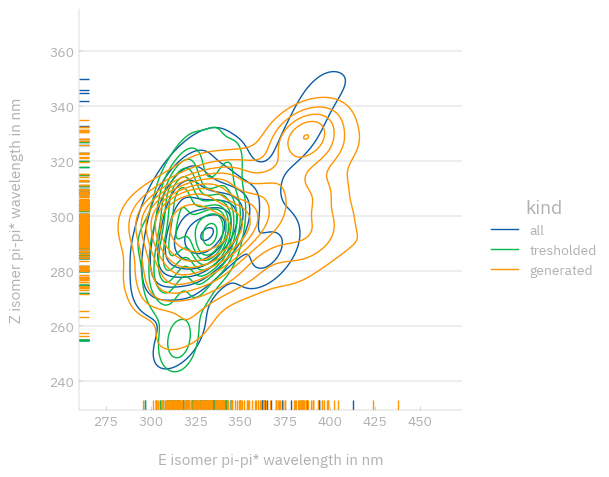

In [28]:
with plt.style.context(matplotx.styles.dufte):
    sns.displot(
        all_data,
        x="E isomer pi-pi* wavelength in nm",
        y="Z isomer pi-pi* wavelength in nm",
        kind="kde",
        hue="kind",
        rug=True,
    )

plt.savefig("extrapolation_photoswitch_dist.pdf", bbox_inches="tight")